<h1 align='center'>Welcome to my Notebook</h1>

# Modified version of: 
https://www.kaggle.com/vagifa/vehicle-insurance-eda-undersampling-lightgbm/notebook


In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold,KFold
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import matthews_corrcoef

import optuna
from optuna.samplers import TPESampler
%config Completer.use_jedi = False

In [ ]:
#train = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
#test = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/test.csv')
#sample = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

sns.set(style='white', context='notebook', palette='deep')

<h1 align='center'>Exploratory Data Analysis</h1>

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [5]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [6]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
train.skew()

id                      9.443274e-16
Age                     6.725390e-01
Driving_License        -2.159518e+01
Region_Code            -1.152664e-01
Previously_Insured      1.677471e-01
Annual_Premium          1.766087e+00
Policy_Sales_Channel   -9.000081e-01
Vintage                 3.029517e-03
Response                2.301906e+00
dtype: float64

In [8]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [9]:
all_features = pd.concat([train.drop(['id','Response'],axis=1),test.drop('id',axis=1)],axis=0)
y = train['Response']

Let's combine the train and test set so our transformations are easier as we don't have to apply them seperately to each set

<h1 align='center'>Categorical Features Data Analysis</h1>

In [10]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

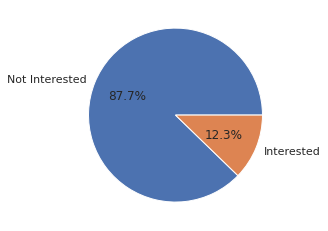

In [11]:
fig1, ax1 = plt.subplots()
ax1.pie(train['Response'].value_counts(), labels=['Not Interested','Interested'], autopct='%1.1f%%')
plt.show()

In [12]:
#fig = px.pie(train,values=train['Response'].value_counts(),names=['Class 0','Class 1'],hole=0.6,labels={0:'Response = 0'},color_discrete_sequence=px.colors.sequential.Sunset)
#fig.show(showlegend=True)
#plt.show()

In [13]:
#fig = px.pie(train,values=train['Response'].value_counts(),names=['Class 0','Class 1'],hole=0.6,labels={0:'Response = 0'},color_discrete_sequence=px.colors.sequential.Sunset)
#fig.show(showlegend=True)

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


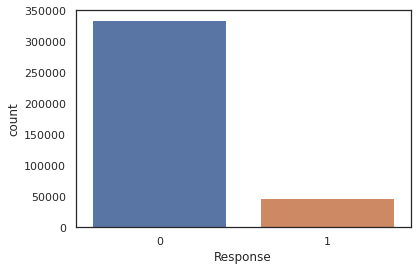

In [14]:
sns.countplot(train['Response'])
plt.show()

We can see from the above visualisations that:

* The Data is highly imbalanced, with 87.7% belonging to Class 0 and 12.3% belonging to Class 1. We will use both UnderSampling and OverSampling to balance the data out equally

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


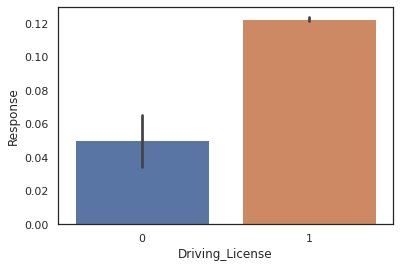

In [15]:
sns.barplot(train['Driving_License'],train['Response'])
plt.show()

Here, we can see that people who have the a driving license are more likely to be interested in getting insurance

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


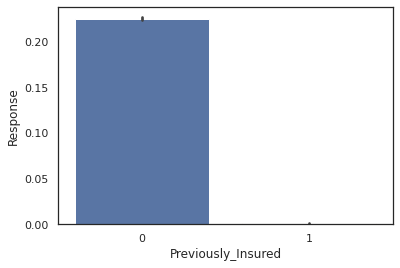

In [16]:
sns.barplot(train['Previously_Insured'],train['Response'])
plt.show()

Now,we see that people who are not previously insured are more likely to be interested in getting insurance, as one does not want to pay for multiple insurances

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


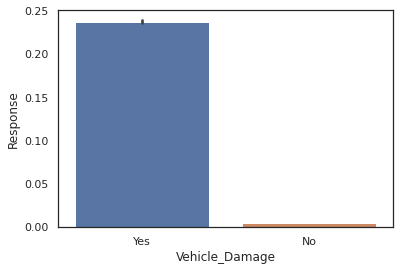

In [17]:
sns.barplot(train['Vehicle_Damage'],train['Response'])
plt.show()

People with vehicle damage are also more likely to be interested in getting insurance, which is self-explanatory

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


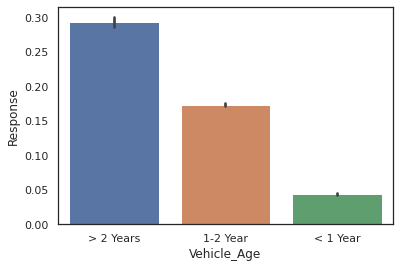

In [18]:
sns.barplot(train['Vehicle_Age'],train['Response'])
plt.show()

Here we see that people with older Vehicles are more likely to be interested. This is obvious, as the longer a vehicle is on the road, the more likely it is to have problems and issues as oppose to new cars

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


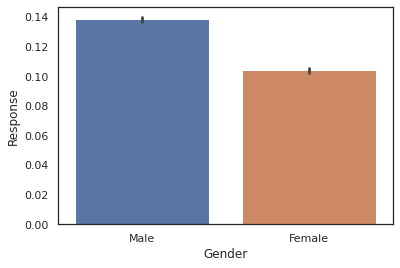

In [19]:
sns.barplot(train['Gender'],train['Response'])
plt.show()

Males are more likely to be interested in getting insured. This could be due to many possible reasons, but one could be just that more males in the dataset.

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


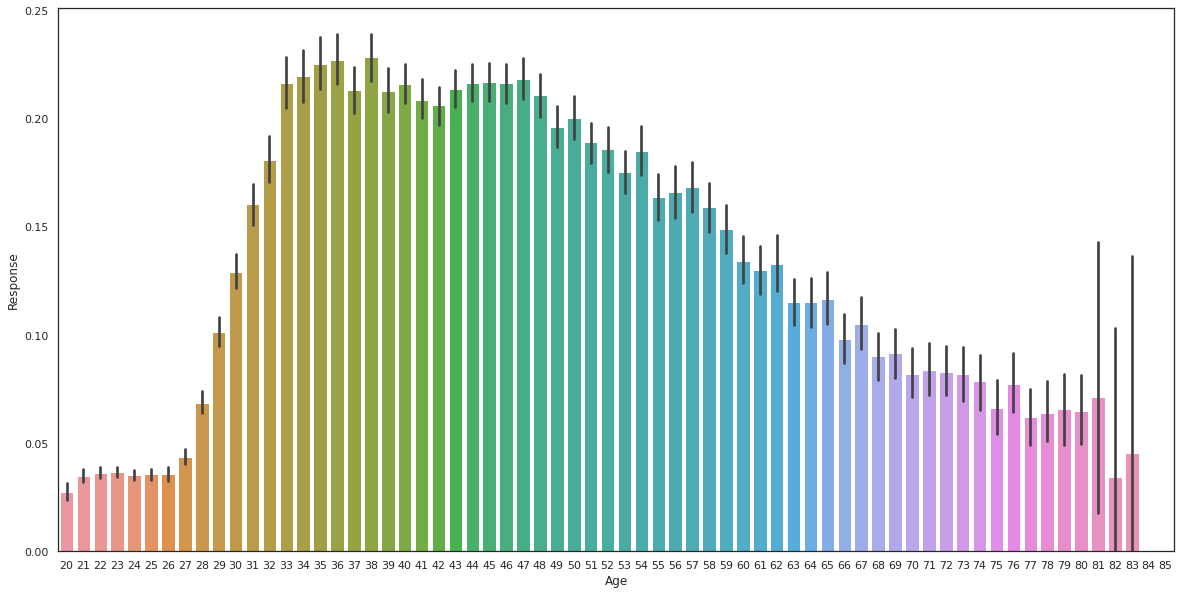

In [20]:
plt.figure(figsize=(20,10))
sns.barplot(train['Age'],train['Response'])
plt.show()

In this visualisation, we see what ages are more likely to be interested in insurance. We see the following things:
1. Ages between 20-27 are not very interested in getting insured. This can be because insurance is not their main priority, and they probably cannot afford it as they are most likely students
2. Ages 30-55 are more interested in getting insured, as they use the car on a day to day basis to travel for work, so they are more in need to repairs 
3. Age 65+ are less likely to be interested in insurance as this is the retirment age and they do not have a need for a car any more, let alone insurance

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


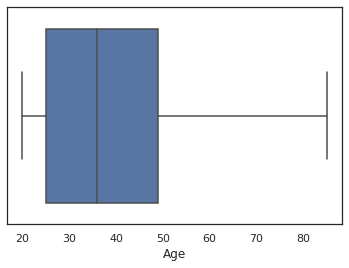

In [21]:
sns.boxplot(train['Age'])
plt.show()

The reason for this boxplot was to see if there was any outliers(in this case, any extreme cases or accidental ages, e.g a 5 year old interested in insurance!)

In [22]:
bins = [20, 30, 40, 50, 60, 70,90]
labels = ['20-27', '28-39', '40-49', '50-59', '60-69', '70+']
age_categories = pd.cut(train['Age'], bins, labels = labels,include_lowest = True)

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


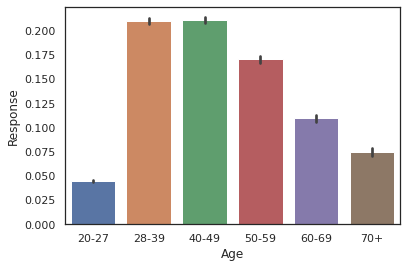

In [23]:
sns.barplot(age_categories,train['Response'])
plt.show()

After splitting the ages into 6 groups, we see that this visualisation confirms our observations from before; the main age groups interested in getting insurance are between 28-50.

<h1 align='center'>Numerical Features Data Analysis</h1>

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


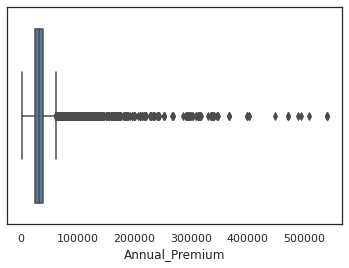

In [24]:
sns.boxplot(train['Annual_Premium'])
plt.show()

We see that Annual Premium has a wide varietly of values

/opt/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


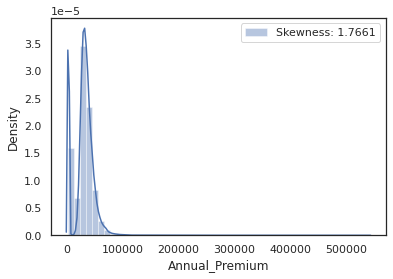

In [25]:
g = sns.distplot(train['Annual_Premium'],label='Skewness: '+str(round(train['Annual_Premium'].skew(),4)))
g = g.legend(loc='best')
plt.show()

Annual Premium is also skewed. We might try a log or square root transformation to mitigate the skewness

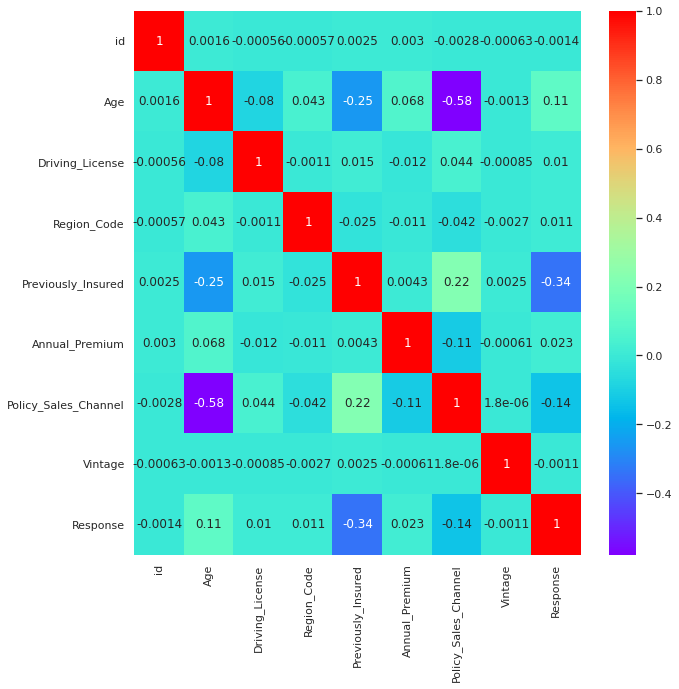

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True,cmap='rainbow')
plt.show()

<h1 align='center'>Feature Preprocessing</h1>

Here we plot a correlation heatmap and see that there is no strong correlation between any feautures and the target feature

In [27]:
all_features['Vehicle_Age'] = all_features['Vehicle_Age'].map({'> 2 Years':2,'1-2 Year':1,'< 1 Year':0})
all_features['Vehicle_Damage'] = all_features['Vehicle_Damage'].map({'Yes':1,'No':0})
all_features['Gender'] = all_features['Gender'].map({'Male':1,'Female':0}) 
all_features

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,1,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,0,0,28619.0,152.0,203
4,0,29,1,41.0,1,0,0,27496.0,152.0,39
...,...,...,...,...,...,...,...,...,...,...
127032,0,26,1,37.0,1,0,0,30867.0,152.0,56
127033,0,38,1,28.0,0,1,1,28700.0,122.0,165
127034,1,21,1,46.0,1,0,0,29802.0,152.0,74
127035,1,71,1,28.0,1,1,0,62875.0,26.0,265


Here we just map categorical values to their appropriate numerical counterparts

<h1 align='center'>Modelling</h1>

In [28]:
X = all_features.iloc[:len(train),:]
X_test = all_features.iloc[len(train):,:]

kf = StratifiedKFold(n_splits=12,shuffle=True,random_state=42)

We define resplit our train and test set, and set up 12 Fold Stratified Cross Validation. It is important to stratify as this ensures that during our training and validation, we split according to target distribution

In [29]:
for train_index,val_index in kf.split(X,y):
    X_train,X_val = X.iloc[train_index],X.iloc[val_index],
    y_train,y_val = y.iloc[train_index],y.iloc[val_index],

In [31]:
# MWB
print(X_train.shape)
print(X_val.shape)
print(X.shape)
print(y.shape)

(349350, 10)
(31759, 10)
(381109, 10)
(381109,)


Here we define our validation set

<h1 align='center'>Modelling Using Undersampling</h1>

We will use `imblearn`'s RandomUnderSampler to undersample from the majority class so that they match

In [32]:
rus = RandomOverSampler(random_state=42)
X_rus,y_rus = rus.fit_sample(X_train,y_train)

<h1 align='center'>Basic LightGBM</h1>

Let's fit a vanilla LGBMClassifier on the undersampled data and evaluate it

In [33]:
lgb_rus = LGBMClassifier(random_state=42)
lgb_rus.fit(X_rus,y_rus)
print(classification_report(y_val,lgb_rus.predict(X_val)))
print('ROC AUC Score: ' + str(roc_auc_score(y_val,lgb_rus.predict(X_val))))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     27867
           1       0.29      0.94      0.44      3892

    accuracy                           0.71     31759
   macro avg       0.64      0.81      0.62     31759
weighted avg       0.90      0.71      0.76     31759

ROC AUC Score: 0.8056953081092022


In [34]:
#MWB
from sklearn.metrics import matthews_corrcoef
y_pred = lgb_rus.predict(X_val)
print(confusion_matrix(y_pred=y_pred, y_true=y_val))
print(f'MCC = {matthews_corrcoef(y_pred=y_pred, y_true=y_val)}')

[[18799  9068]
 [  246  3646]]
MCC = 0.4091840544881246


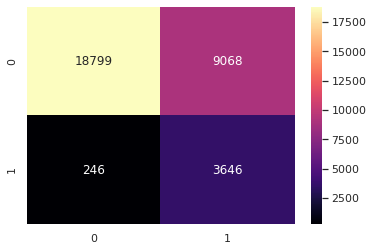

In [35]:
sns.heatmap(confusion_matrix(y_val,lgb_rus.predict(X_val)),cmap='magma',annot=True,fmt='g')
plt.show()

Our model did suprisingly well with default parameters, but not fantastic. Let's optimize

<h1 align='center'>Hyperparameter Tuning</h1>

In [36]:
def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators',100,500)
    num_leaves = trial.suggest_int('num_leaves',10,500)
    max_depth = trial.suggest_int('max_depth',4,20)
    learning_rate = trial.suggest_uniform('learning_rate',0.0001,1)
    min_child_samples = trial.suggest_int('min_child_samples',10,50)
    model = LGBMClassifier(n_estimators=n_estimators,num_leaves=num_leaves,
    max_depth=max_depth,learning_rate=learning_rate,min_child_samples=min_child_samples)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_rus,y_rus)
    #score = roc_auc_score(y_val,model.predict(X_val))
    score = matthews_corrcoef(y_val,model.predict(X_val))  # MWB
    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(sampler=sampler,direction='maximize')
study.optimize(objective,n_trials=60)

[I 2021-11-29 15:58:35,086] A new study created in memory with name: no-name-a9475f95-3c55-46f3-9382-408c667f8bb7
[I 2021-11-29 15:58:44,371] Trial 0 finished with value: 0.29900251581432613 and parameters: {'n_estimators': 250, 'num_leaves': 476, 'max_depth': 16, 'learning_rate': 0.5986986183486169, 'min_child_samples': 16}. Best is trial 0 with value: 0.29900251581432613.
[I 2021-11-29 15:58:47,068] Trial 1 finished with value: 0.39922090995664644 and parameters: {'n_estimators': 162, 'num_leaves': 38, 'max_depth': 18, 'learning_rate': 0.6011549002420344, 'min_child_samples': 39}. Best is trial 1 with value: 0.39922090995664644.
[I 2021-11-29 15:58:50,998] Trial 2 finished with value: 0.37826392208329274 and parameters: {'n_estimators': 108, 'num_leaves': 486, 'max_depth': 18, 'learning_rate': 0.21241787676720833, 'min_child_samples': 17}. Best is trial 1 with value: 0.39922090995664644.
[I 2021-11-29 15:58:55,238] Trial 3 finished with value: 0.3724873577842669 and parameters: {'n_e

[I 2021-11-29 16:02:08,252] Trial 30 finished with value: 0.3829624967899356 and parameters: {'n_estimators': 280, 'num_leaves': 371, 'max_depth': 10, 'learning_rate': 0.23239604485107337, 'min_child_samples': 46}. Best is trial 26 with value: 0.40865585672294624.
[I 2021-11-29 16:02:13,947] Trial 31 finished with value: 0.4083648328575246 and parameters: {'n_estimators': 242, 'num_leaves': 452, 'max_depth': 7, 'learning_rate': 0.10252336862666626, 'min_child_samples': 37}. Best is trial 26 with value: 0.40865585672294624.
[I 2021-11-29 16:02:19,312] Trial 32 finished with value: 0.4087785606030528 and parameters: {'n_estimators': 235, 'num_leaves': 465, 'max_depth': 6, 'learning_rate': 0.07118597442066438, 'min_child_samples': 39}. Best is trial 32 with value: 0.4087785606030528.
[I 2021-11-29 16:02:23,825] Trial 33 finished with value: 0.4095706693990336 and parameters: {'n_estimators': 239, 'num_leaves': 474, 'max_depth': 5, 'learning_rate': 0.17317999847277454, 'min_child_samples':

In [35]:
lgb_params = study.best_params
lgb_params['random_state'] = 42
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_rus, y_rus)
preds = lgb.predict(X_val)
print(classification_report(y_val,lgb.predict(X_val)))
print('ROC AUC Score: ' + str(roc_auc_score(y_val,lgb.predict(X_val))))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     27867
           1       0.29      0.93      0.44      3892

    accuracy                           0.71     31759
   macro avg       0.64      0.80      0.62     31759
weighted avg       0.90      0.71      0.76     31759

ROC AUC Score: 0.8049223017968443


In [37]:
lgb_params = study.best_params
lgb_params['random_state'] = 42
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_rus, y_rus)
preds = lgb.predict(X_val)
print(classification_report(y_val,lgb.predict(X_val)))
print('ROC AUC Score: ' + str(roc_auc_score(y_val,lgb.predict(X_val))))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     27867
           1       0.29      0.91      0.44      3892

    accuracy                           0.72     31759
   macro avg       0.64      0.80      0.63     31759
weighted avg       0.90      0.72      0.77     31759

ROC AUC Score: 0.8038184265807293


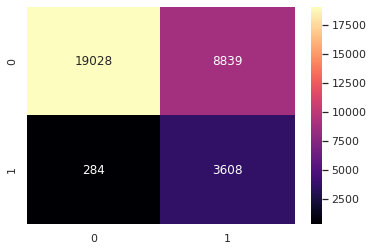

In [36]:
sns.heatmap(confusion_matrix(y_val,lgb.predict(X_val)),cmap='magma',annot=True,fmt='g')
plt.show()

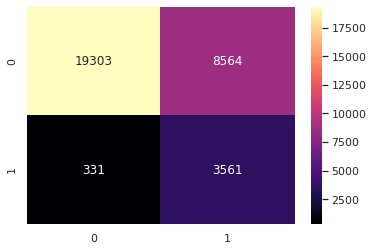

In [38]:
sns.heatmap(confusion_matrix(y_val,lgb.predict(X_val)),cmap='magma',annot=True,fmt='g')
plt.show()

In [37]:
#MWB - old
lgb_params

{'n_estimators': 273,
 'num_leaves': 342,
 'max_depth': 4,
 'learning_rate': 0.13798553166412442,
 'min_child_samples': 46,
 'random_state': 42}

In [39]:
#MWB - new
lgb_params

{'n_estimators': 125,
 'num_leaves': 323,
 'max_depth': 6,
 'learning_rate': 0.2982233778503205,
 'min_child_samples': 29,
 'random_state': 42}

<h1 align='center'>Thanks and make sure to learn!</h1>